<a href="https://colab.research.google.com/github/chunyulin/tf2020ncku/blob/master/0_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get familiar with your free GPU resource
* Colab as the linux box with root premission.
* You cab mount Google Drive to the colab box.
* You can load ipython from Github directly, or checkout the whole github repository (though not really needed).
* All data here are temporary. You would like to save on Google drive, github, or your own server.


In [0]:
# For those familiar with Linux -- You just own a virtual machine with root
!whoami
!pwd
!free -h
!df -h
#!ls /



In [0]:
###  Check your TF version and GPU hardware
import tensorflow as tf
#import tensorflow.compat.v1 as tf
from tensorflow.python.client import device_lib

print ("Using Tensorflow: ", tf.__version__)
print ( device_lib.list_local_devices() )
!nvidia-smi

In [0]:
## All data here are temporary. You would like to save on Google drive, github, or your own server.
# You cab mount Google Drive
# Or just wget from other storage you have, such as S3, HTTP,...

from google.colab import drive
drive.mount('/content/drive')
#!ls /content/drive/'My Drive'

In [0]:
import os
GIT_USERNAME = "chunyulin"
GIT_REPOSITORY = "test"     # git repository

#GIT_TOKEN = "XXXX"          # only need for private git repository
#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git"
GIT_PATH = "https://github.com/%s/%s.git" % ( GIT_USERNAME, GIT_REPOSITORY )

!git clone "{GIT_PATH}"     ## {} is only valid in bash
!ls

# A simple TensorFlow task : MNIST
Example from https://www.tensorflow.org/tutorials/quickstart/advanced

* Load data: `tf.keras.datasets.mnist.load_data()`
* Prepare TF dataset: `tf.data.Dataset`
* Design model: `class MyModel(Model)`
* Perform Training via `tf.keras`

### Some note about TF model.
* There are many approached to write a model. See [the blog](https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/).
* Subclass model may not sequencial and is not static. Some function are not support. See [this duscussion](https://stackoverflow.com/questions/51806852/cant-save-custom-subclassed-model).

In [0]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

#a = np.array(range(10)).reshape([2,5])
#a[...,3]

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [0]:
## Before training, let's have a look on the data
import matplotlib.pyplot as plt
ID=111
plt.imshow(x_train[ID,...,0])
plt.title("MNIST: %d" % y_train[ID])
plt.show()

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    #self.conv2 = Conv2D(64, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax', name="predict")

  def call(self, x):
    x = self.conv1(x)
    #x = self.conv2(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
tf.compat.v1.reset_default_graph()
model = MyModel()

# Define loss and optimzer
#loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
#optimizer = tf.keras.optimizers.Adam()
#model.build( input_shape=(None, 28,28,1) )


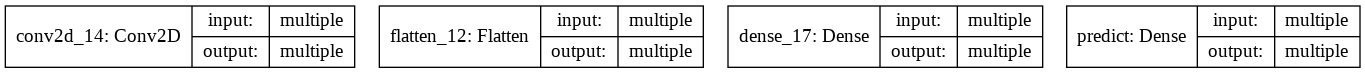

In [192]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [0]:
## The decorator `@tf.function` introduced for TF2
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [185]:
EPOCHS = 10

train_loss_history = []
test_loss_history = []

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  train_loss_history.append(np.mean(train_loss.result()))
  test_loss_history.append(np.mean(test_loss.result()))

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.13921049237251282, Accuracy: 95.86499786376953, Test Loss: 0.06260816007852554, Test Accuracy: 97.97999572753906
Epoch 2, Loss: 0.043844401836395264, Accuracy: 98.66500091552734, Test Loss: 0.05290108174085617, Test Accuracy: 98.31999969482422
Epoch 3, Loss: 0.021380756050348282, Accuracy: 99.30833435058594, Test Loss: 0.05380738526582718, Test Accuracy: 98.31999969482422
Epoch 4, Loss: 0.014774051494896412, Accuracy: 99.5, Test Loss: 0.052122876048088074, Test Accuracy: 98.549995422363

In [0]:
## Monitor the training behavior.
## Can be replace with other tools like TensorBoard.
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.legend()

# Another way to train


In [0]:
# Another way to train:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy())
his = model.fit(x_train, y_train, batch_size=64, epochs=10,
                    validation_data=(x_test, y_test))

In [0]:
plt.plot(his.history['loss'], label="train loss")
plt.plot(his.history['val_loss'], label="val loss")
plt.legend()
plt.show()

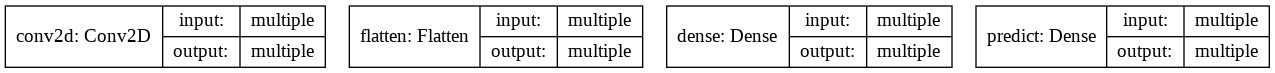

In [203]:
#model.summary()
plot_model(model, show_shapes=True, to_file='model.png')

In [0]:
for images,labels in test_ds.take(2):
  print(images.shape)  ## (32, 28, 28, 1)
  im = images[7:8]     ## take 6th image out of the batch.
  print("Predict: ", model(im).numpy().argmax())
  plt.imshow(im.numpy().reshape(28,28))
  plt.show()


In [210]:
# Make prediction via `model.predict()` for multimple sample
for images,labels in test_ds.take(1):
  pre = model.predict(images).argmax(axis=1)
  print( pre)
  print( labels)
  print( pre-labels.numpy())
  


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 5 4 9 6 6 5 4 0 7 4 0 1 3 1]
tf.Tensor([7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1], shape=(32,), dtype=uint8)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
MODEL_PATH="./model/mnist_v0"
tf.saved_model.save(model, MODEL_PATH)   ##  It seems TF can create an folder if not existed.


In [0]:
GD_PATH="/content/drive/'My Drive'/Colab_shared"
#!cp -r {MODEL_PATH} {GD_PATH}/

## Or, compress the folder to save space before copy
##!tar czvf model.tgz {MODEL_PATH}
##!cp model.tgz {GD_PATH}

### It seems Colab doesn't allow downloading large files
# from google.colab import files
# files.download(MODEL_FILE)


* Let's save it in your github. And open a new colab to use the saved model.
